# Enumerating the RTC-S1 Inputs for a *single* DIST-S1 input.

In this notebook, we provide an interactive demonstration illustrating how to take an Area of Interest (AOI), select overlapping MGRS tiles of said AOI, and then retreive the necessary RTC-S1 inputs for a DIST-S1 product. In doing this, we hope to illustrate how the rules governing this RTC-S1 input curation for DIST-S1.

Recall that DIST-S1 products (just like DIST-HLS) will be located in an MGRS tile. This notebook assumes were are generating a single product in an MGRS tile, which the user chooses based on their AOI.

The next notebook will show how to quickly enumerate multiple products over larger areas.

The unique identifiers for a DIST-S1 product (and it's input) are:

1. MGRS tile
2. Track Number(s) for a Sentinel-1 pass
3. Time of post-image acquisition (within 1 day)

There are some strategies for selecting pre-images, but if we assume that for operations these are fixed, then the above can be used to uniquely determine a DIST-S1 product. We go through the inspection of these fields.

The reason we may have multiple track numbers is that at the equator the track numbers are incremented by 1, so a single pass of data have two sequential pass numbers. We have created a lookup table (LUT) for ensuring we always group burst ids within an MGRS tile associated to a single Sentinel-1 pass.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime, timedelta
from pathlib import Path

import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from rasterio.crs import CRS
from shapely.geometry import Point

from dist_s1_enumerator import (
    enumerate_one_dist_s1_product,
    get_burst_ids_in_mgrs_tiles,
    get_burst_table_from_mgrs_tiles,
    get_lut_by_mgrs_tile_ids,
    get_mgrs_tiles_overlapping_geometry,
    get_rtc_s1_ts_metadata_from_mgrs_tiles,
)
from dist_s1_enumerator.rtc_s1_io import localize_rtc_s1_ts

# Specifiy an AOI

This AOI could be a point or a polygon. Although this is not for the DIST-S1 specifically, it allows us to view the inputs/products over a particular area. This is all in lon/lat (`epsg:4326`).

In [3]:
# Over Los Padres National Forest, CA
point = Point(-120.0048, 34.8923)
df_aoi = gpd.GeoDataFrame(geometry=[point], crs=CRS.from_epsg(4326))

# Get Overlapping MGRS Tiles

Obtain a geo-table with MGRS extent metadata overlapping our AOI.

In [4]:
df_mgrs_tiles = get_mgrs_tiles_overlapping_geometry(point)
df_mgrs_tiles.head()

,mgrs_tile_id,utm_epsg,utm_wkt,geometry
0,10SGD,32610,"MULTIPOLYGON(((699960 3900000,699960 3790200,8...","POLYGON ((-120.8029 35.22313, -120.82894 34.23..."
1,11SKU,32611,"MULTIPOLYGON(((199980 3900000,199980 3790200,3...","POLYGON ((-120.29518 35.19821, -120.25618 34.2..."


## Visualize Overlapping Tiles and AOI

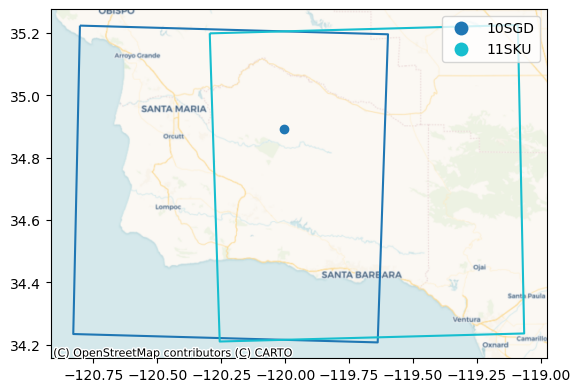

In [5]:
fig, ax = plt.subplots()
df_mgrs_tiles_plot = df_mgrs_tiles.copy()
df_mgrs_tiles_plot.geometry = df_mgrs_tiles_plot.geometry.boundary
df_mgrs_tiles_plot.plot(column="mgrs_tile_id", categorical=True, legend=True, ax=ax)
df_aoi.plot(ax=ax)
ctx.add_basemap(ax, crs=df_mgrs_tiles.crs.to_string(), source=ctx.providers.CartoDB.Voyager)

# 1. Select the MGRS Tile

Now, we want to visualize the overlapping spatially-fixed S1 burst extents (keyed by `jpl_burst_id`), which are precisely the RTC-S1 product extents. 

First select an MGRS tile from the one of those above. This effectively allows us to get 1. from the list at the beginning! So we have checked off one identifier of the DIST-S1 product.

In [6]:
MGRS_TILE_ID = "10SGD"

## Visualize The Overlapping Tracks/Bursts

Now, we want to get all the bursts that overlap said MGRS tile.

In [7]:
df_bursts = get_burst_table_from_mgrs_tiles([MGRS_TILE_ID])
df_bursts.head()

,jpl_burst_id,track_number,acq_group_id_within_mgrs_tile,mgrs_tile_id,geometry
0,T035-073228-IW3,35,0,10SGD,"POLYGON ((-121.08528 34.05287, -120.22744 34.1..."
1,T035-073229-IW3,35,0,10SGD,"POLYGON ((-121.11788 34.21917, -120.25912 34.3..."
2,T035-073230-IW3,35,0,10SGD,"POLYGON ((-121.15285 34.38514, -120.29232 34.5..."
3,T035-073231-IW3,35,0,10SGD,"POLYGON ((-121.18785 34.55111, -120.32556 34.6..."
4,T035-073232-IW3,35,0,10SGD,"POLYGON ((-121.22291 34.71708, -120.35882 34.8..."


Under the hood, this function uses a lookup table (LUT) that allows us to do the following:

1. Get all the `jpl_burst_id`'s from a given `mgrst_tile_id`.
2. Get all the `mgrs_tile-ids`'s from a given `jpl_burst_id`.

This relationship is many-to-many as MGRS tiles overlap with one another as do the spatially-fixed burst extents. To see how the LUT was generated you can see this [notebook](https://github.com/OPERA-Cal-Val/dist-s1-research/blob/dev/marshak/R_mgrs_burst_lookup/Lookup%20Tables%20for%20MGRS%20and%20Bursts.ipynb). We can inspect subsets of the lut table with the function below.

In [8]:
df_mgrs_burst_luts = get_lut_by_mgrs_tile_ids([MGRS_TILE_ID])
df_mgrs_burst_luts.head()

,jpl_burst_id,mgrs_tile_id,track_number,acq_group_id_within_mgrs_tile,orbit_pass,area_per_acq_group_km2,n_bursts_per_acq_group
0,T035-073228-IW3,10SGD,35,0,ASCENDING,7127,7
1,T035-073229-IW3,10SGD,35,0,ASCENDING,7127,7
2,T035-073230-IW3,10SGD,35,0,ASCENDING,7127,7
3,T035-073231-IW3,10SGD,35,0,ASCENDING,7127,7
4,T035-073232-IW3,10SGD,35,0,ASCENDING,7127,7


Now, let's visualize the MGRS tile we selected and all the spatially fixed bursts. Recall that a track number indicates a group of bursts that are collected from a single Sentinel-1 pass.

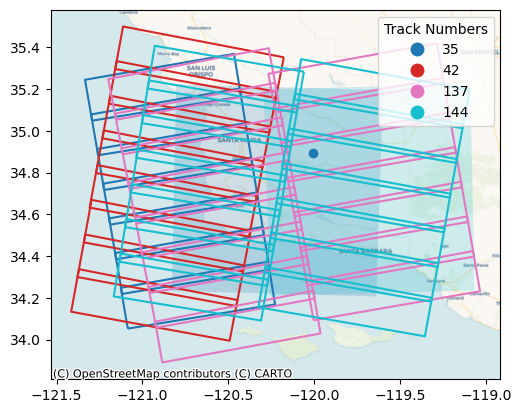

In [9]:
fig, ax = plt.subplots()
df_mgrs_tiles_plot = df_mgrs_tiles.copy()
df_mgrs_tiles_plot.plot(column="mgrs_tile_id", categorical=True, ax=ax, alpha=0.2)
df_aoi.plot(ax=ax)
df_bursts_plot = df_bursts.copy()
df_bursts_plot.geometry = df_bursts_plot.geometry.boundary
df_bursts_plot.plot(column="track_number", categorical=True, ax=ax, legend=True)
leg = ax.get_legend()
leg.set_title("Track Numbers")
ctx.add_basemap(ax, crs=df_mgrs_tiles.crs.to_string(), source=ctx.providers.CartoDB.Voyager)

# 2. Select the Track Number

Selecting the track number specify the second identifier of the DIST-S1 product. This identifier represents the group of bursts that will be collected from a single S1 pass.

A minor note that we reiterate is what occurs at the equator. A track will increment by 1 (that is, a track `n` will become `n+1`) within a single MGRS tile. This is taken care of in the function below if only one of the two tracks are provided. If multiple tracks are provided, the function assumes they are coming from a single pass so the tracks should be within 1 of each other (a `ValueError` will be raised otherwise).

In [10]:
TRACK_NUMBER = 137

In [11]:
burst_ids_in_track = get_burst_ids_in_mgrs_tiles([MGRS_TILE_ID], track_numbers=[TRACK_NUMBER])
burst_ids_in_track

['T137-292318-IW1',
 'T137-292318-IW2',
 'T137-292319-IW1',
 'T137-292319-IW2',
 'T137-292320-IW1',
 'T137-292320-IW2',
 'T137-292321-IW1',
 'T137-292321-IW2',
 'T137-292322-IW1',
 'T137-292322-IW2',
 'T137-292323-IW1',
 'T137-292323-IW2',
 'T137-292324-IW1',
 'T137-292324-IW2',
 'T137-292325-IW1']

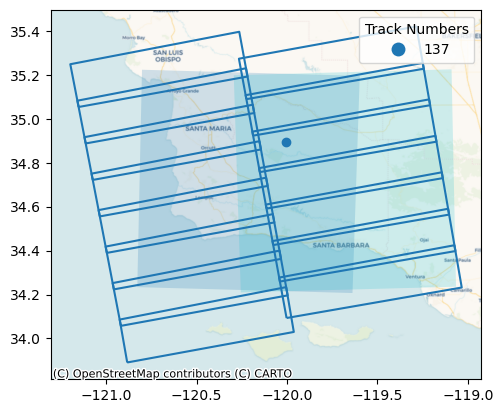

In [12]:
fig, ax = plt.subplots()
df_mgrs_tiles_plot = df_mgrs_tiles.copy()
df_mgrs_tiles_plot.plot(column="mgrs_tile_id", categorical=True, ax=ax, alpha=0.2)
df_aoi.plot(ax=ax)
df_bursts_plot_track = df_bursts_plot[df_bursts_plot.jpl_burst_id.isin(burst_ids_in_track)].reset_index(drop=True)
df_bursts_plot_track.plot(column="track_number", categorical=True, ax=ax, legend=True)
leg = ax.get_legend()
leg.set_title("Track Numbers")
ctx.add_basemap(ax, crs=df_mgrs_tiles.crs.to_string(), source=ctx.providers.CartoDB.Voyager)

# Get Candidate Post-Image set of RTC-S1 Data (Post-images)

Now, we want to get the final identifier - time of post-image acquisition within 1 day.

We inspect possible set of post-images in the last 30 days.

In [13]:
today = datetime.today()
df_rtc_post_possible = get_rtc_s1_ts_metadata_from_mgrs_tiles(
    [MGRS_TILE_ID], track_numbers=[TRACK_NUMBER], start_acq_dt=today, stop_acq_dt=today - timedelta(days=30)
)
df_rtc_post_possible.head()

,opera_id,jpl_burst_id,acq_dt,acq_date_for_mgrs_pass,polarizations,track_number,pass_id,url_crosspol,url_copol,geometry,mgrs_tile_id,acq_group_id_within_mgrs_tile,track_token
0,OPERA_L2_RTC-S1_T137-292318-IW1_20241127T01590...,T137-292318-IW1,2024-11-27 01:59:00+00:00,2024-11-27,VV+VH,137,663,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-120.88201 33.89008, -119.86899 34.0...",10SGD,2,137
1,OPERA_L2_RTC-S1_T137-292318-IW2_20241127T01590...,T137-292318-IW2,2024-11-27 01:59:01+00:00,2024-11-27,VV+VH,137,663,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-120.00205 34.08588, -118.9574 34.23...",10SGD,2,137
2,OPERA_L2_RTC-S1_T137-292319-IW1_20241127T01590...,T137-292319-IW1,2024-11-27 01:59:03+00:00,2024-11-27,VV+VH,137,663,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-120.92073 34.05617, -119.90835 34.2...",10SGD,2,137
3,OPERA_L2_RTC-S1_T137-292319-IW2_20241127T01590...,T137-292319-IW2,2024-11-27 01:59:04+00:00,2024-11-27,VV+VH,137,663,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-120.039 34.25219, -118.99203 34.406...",10SGD,2,137
4,OPERA_L2_RTC-S1_T137-292320-IW2_20241127T01590...,T137-292320-IW2,2024-11-27 01:59:06+00:00,2024-11-27,VV+VH,137,663,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-120.07407 34.41866, -119.0143 34.57...",10SGD,2,137


Let's visualize the dates/times.

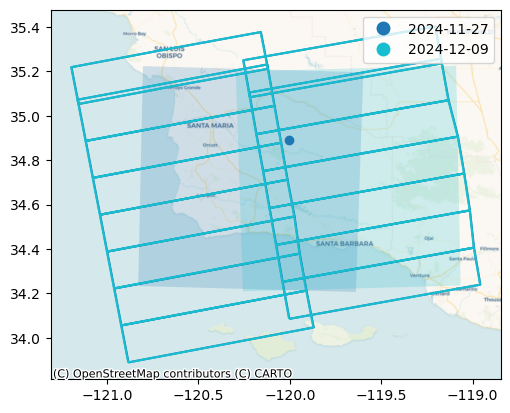

In [14]:
fig, ax = plt.subplots()
df_mgrs_tiles_plot.plot(column="mgrs_tile_id", categorical=True, ax=ax, alpha=0.2)
df_aoi.plot(ax=ax)
df_rtc_plot = df_rtc_post_possible.copy()
df_rtc_plot.geometry = df_rtc_plot.geometry.boundary
df_rtc_plot.plot(column="acq_date_for_mgrs_pass", categorical=True, ax=ax, legend=True)
ctx.add_basemap(ax, crs=df_mgrs_tiles_plot.crs.to_string(), source=ctx.providers.CartoDB.Voyager)

## Few minor notes
1. The geometries from our burst table differ from those collected from the DAAC (this can be seen in the overlap).
2. In some cases, the burst ids collected from the latest pass will equal the total fixed bursts requested. In some cases, the actual data from the latest pass will be *less* than the requested bursts. This is due to S1 availability.

# 3. Select the post-image acquisition date

Now, we are in position to specify the last identifier for DIST-S1 and enumerate the inputs. This is the time that the post-image products are collected. We will select the most recent pass.

In [15]:
# most recent pass
post_date = df_rtc_post_possible.acq_dt.dt.date.max()

# Enumerate Inputs for a DIST-S1 Product

The function below enumerates all the inputs (in the form of a table) of a single DIST-S1 product.

The pre-images and post-images are clarified in the column `input_category`.

In [16]:
df_product = enumerate_one_dist_s1_product(MGRS_TILE_ID, track_number=TRACK_NUMBER, post_date=post_date)
df_product.head()

,opera_id,jpl_burst_id,acq_dt,acq_date_for_mgrs_pass,polarizations,track_number,pass_id,url_crosspol,url_copol,geometry,mgrs_tile_id,acq_group_id_within_mgrs_tile,track_token,input_category
0,OPERA_L2_RTC-S1_T137-292318-IW1_20231215T01590...,T137-292318-IW1,2023-12-15 01:59:04+00:00,2023-12-15,VV+VH,137,605,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-120.88361 33.88987, -119.8707 34.04...",10SGD,2,137,pre
1,OPERA_L2_RTC-S1_T137-292318-IW2_20231215T01590...,T137-292318-IW2,2023-12-15 01:59:05+00:00,2023-12-15,VV+VH,137,605,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-120.00377 34.08578, -118.9592 34.23...",10SGD,2,137,pre
2,OPERA_L2_RTC-S1_T137-292319-IW1_20231215T01590...,T137-292319-IW1,2023-12-15 01:59:06+00:00,2023-12-15,VV+VH,137,605,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-120.92239 34.0562, -119.91011 34.21...",10SGD,2,137,pre
3,OPERA_L2_RTC-S1_T137-292319-IW2_20231215T01590...,T137-292319-IW2,2023-12-15 01:59:07+00:00,2023-12-15,VV+VH,137,605,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-120.04081 34.25246, -118.99391 34.4...",10SGD,2,137,pre
4,OPERA_L2_RTC-S1_T137-292320-IW1_20231215T01590...,T137-292320-IW1,2023-12-15 01:59:09+00:00,2023-12-15,VV+VH,137,605,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-120.96121 34.2224, -119.94684 34.37...",10SGD,2,137,pre


# Localizing Inputs

This library also provides a mechanism to download the data specified in the table. We illustrate this now.

We highlight that we download items in a very specific way i.e. organizing the RTC inputs in a way that is conducive to dragging them into QGIS or other visualization client. It will also be used by the DIST-S1 workflow.

In [17]:
out_dir = Path("out")
out_dir.mkdir(exist_ok=True, parents=True)

In [18]:
df_product_loc = localize_rtc_s1_ts(df_product, out_dir, max_workers=5)

100%|█████████| 330/330 [00:00<00:00, 637256.13it/s]


In [20]:
track_token = df_product_loc.track_token.iloc[0]
mgrs_tile_id = df_product_loc.mgrs_tile_id.iloc[0]
date_token = df_product_loc.acq_date_for_mgrs_pass.iloc[0]

df_product_loc.to_parquet(f"{mgrs_tile_id}__{track_token}__{date_token}_dist_s1_inputs.parquet")

## Additional Notes

This notebook is primarily to explain and interact with `enumerate_one_dist_s1_product`. This function hits the ASF DAAC twice (once for the post-image set and once for the pre-image set).

In the next notebook, we will get a full time-series over an MGRS tile (spanning multiple tracks) and enumerate the products over that MGRS tile all at once. This means we only will need to hit the DAAC once to get the entire time-series.